### MonthlySVD
This code shows as simple way to:
- Read in a .nc file using xarray
- Generate montly anomalies from climatology of monthly means
- detrend data by grid cell
- calculate singular value decomposition by grid cell, dim = month * year


In [1]:
import xarray as xr
import cf_units as cf
import numpy as np
import pandas as pd
import esmlab
from ctsm_py import utils

# Try scipy to detrend
import segment as sg
import scipy
from scipy import signal

# some resources for plotting
import matplotlib.pyplot as plt
#import cartopy
#import cartopy.crs as ccrs
%matplotlib inline

In [2]:
## User defined options
model = 'CLM5_GSWP3'
var  = ['GPP','TBOT','SOILWATER_10CM']
suff = 'lnd/proc/tseries/month_1/'
path = '/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist/'+suff
file0 = path + 'clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.'+ var[0] +'.185001-201412.nc'
file1 = path + 'clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.'+ var[1] +'.185001-201412.nc'
file2 = path + 'clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.'+ var[2] +'.185001-201412.nc'
file0

'/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist/lnd/proc/tseries/month_1/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.GPP.185001-201412.nc'

#### Read in data

In [3]:
# wrapping the time_set_mid utility corrects time being read in by xr.open_dataset
# data sets have lots of coords, variables, and attributes
# ?? TODO, is there a more efficient way of reading in multiple variables into a signle dataset??
ds0   = utils.time_set_mid(xr.open_dataset(file0, decode_times=True), 'time')
ds1   = utils.time_set_mid(xr.open_dataset(file1, decode_times=True), 'time')
ds2   = utils.time_set_mid(xr.open_dataset(file2, decode_times=True), 'time')
area = ds0.area
landfrac = ds0.landfrac
ds = xr.merge([ds0, ds1, ds2])
print(ds)

<xarray.Dataset>
Dimensions:         (hist_interval: 2, lat: 192, levdcmp: 25, levgrnd: 25, levlak: 10, lon: 288, time: 1980)
Coordinates:
  * lat             (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
  * levdcmp         (levdcmp) float32 0.01 0.04 0.09 ... 28.870724 41.998436
  * levgrnd         (levgrnd) float32 0.01 0.04 0.09 ... 28.870724 41.998436
  * levlak          (levlak) float32 0.05 0.6 2.1 4.6 ... 25.6 34.325 44.775
  * lon             (lon) float32 0.0 1.25 2.5 3.75 ... 356.25 357.5 358.75
  * time            (time) object 1850-01-16 11:45:00 ... 2014-12-16 12:00:00
Dimensions without coordinates: hist_interval
Data variables:
    BSW             (levgrnd, lat, lon) float32 nan nan nan nan ... nan nan nan
    DZLAKE          (levlak, lat, lon) float32 nan nan nan nan ... nan nan nan
    DZSOI           (levgrnd, lat, lon) float32 0.02 0.02 0.02 ... nan nan nan
    GPP             (time, lat, lon) float32 ...
    HKSAT           (levgrnd, lat, lon) float32

### Quick look at annual cycle for a grid cell

In [34]:
years = 25
months = years * 12
tlat = 60 #-5
tlon = 240# 300
ds_test = ds.sel(lat=tlat, lon=tlon, method='nearest') #select a single grid point to work with first
ds_last = ds_test.isel(time=slice(-months,None))
dataset = ds_last.get(var)
ds_ann  = dataset.apply(utils.weighted_annual_mean)
plt.plot(ds_last.time['time'], ds_last.get(var[0]), '-' );
plt.plot(ds_ann.time['time'], ds_ann.get(var[0]), '-' );

### Calculate climatology and anomalies

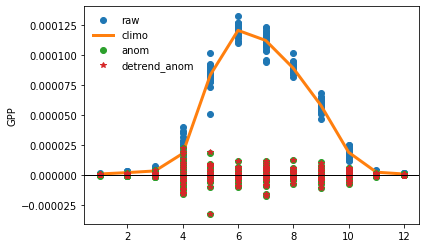

In [35]:
# esmlab anomaly function needs time_bounds in the dataset!
# test to see of climatology and anomaly functions see to work appropriately?
ds_climo = esmlab.core.climatology(ds_last,freq='mon')
ds_anom = esmlab.core.anomaly(ds_last, clim_freq='mon', time_coord_name='time')
ds_detrend0 = signal.detrend(ds_anom.get(var[0]))
ds_detrend1 = signal.detrend(ds_anom.get(var[1]))
ds_detrend2 = signal.detrend(ds_anom.get(var[2]))

plt.plot(ds_last.time['time.month'], ds_last.get(var[0]), 'o' );
plt.plot(ds_climo.time['time.month'], ds_climo.get(var[0]), '-', lw=3 );
plt.plot(ds_anom.time['time.month'], ds_anom.get(var[0]), 'o' );
plt.plot(ds_anom.time['time.month'], ds_detrend0, '*' );
plt.legend(labels=('raw','climo','anom','detrend_anom'),frameon = False)
plt.axhline(0, color='black', lw=1);
plt.ylabel(var[0]);


In [36]:
# now look at temp and soil moisture anomalies
plt.subplot(1, 2, 1)
plt.plot(ds_last.time['time.month'], ds_last.get(var[1])-273.15, 'o' );
plt.plot(ds_climo.time['time.month'], ds_climo.get(var[1])-273.15, '-', lw=3 );
plt.plot(ds_anom.time['time.month'], ds_anom.get(var[1]), 'o' );
plt.plot(ds_anom.time['time.month'], ds_detrend1, '*' );
plt.axhline(0, color='black', lw=1);
plt.ylabel(var[1])

plt.subplot(1, 2, 2)
plt.plot(ds_last.time['time.month'], ds_last.get(var[2]), 'o' );
plt.plot(ds_climo.time['time.month'], ds_climo.get(var[2]), '-', lw=3 );
plt.plot(ds_anom.time['time.month'], ds_anom.get(var[2]), 'o' );
plt.plot(ds_anom.time['time.month'], ds_detrend2, '*' );
plt.axhline(0., color='black', lw=1);
plt.ylabel(var[2]);

 ### Do we need to detrend data?

In [37]:
plt.plot(ds_anom.time['time'], ds_anom.get(var[0]), '-',c='green' )
plt.plot(ds_anom.time['time'], ds_detrend0, '-' ,c='red');

### Start singular vector decomposition
#### This is from Gretchen's CLM_SVD code 

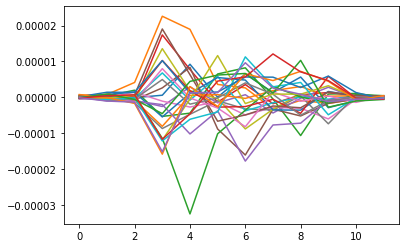

In [38]:
# orig. mon x year
iavmatrix_orig=np.zeros([12, years])
for iyr in range(years):
    iavmatrix_orig[0:12, iyr]=ds_detrend0[iyr*12:(iyr+1)*12] #reshape timeseries vector into a matrix (year x month) 

plt.figure();
plt.plot(iavmatrix_orig) ; #this plots months on x-axis, 1 line/year

In [39]:
monthlimits=np.array([0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
DOYlimits=np.cumsum(monthlimits)
print(iavmatrix_orig.shape)

(12, 25)


### Now try using SVD_tools.py

In [40]:
import SVD_tools as svd
#assign the 2-D matrix (month x year) to decompose
## TODO, the decompose functions doesn't like to work with too many years of data?  
[vectors, weights]=svd.decompose(iavmatrix_orig) #Call the function to calculate the singular vectors and their annual weights
print(vectors.shape)

[theta,varfrac]=svd.calc_redistribution(vectors, weights, iavmatrix_orig)
varfrac.shape

12 25
(25, 12)
[0.49559711 0.87611976 0.41423303 0.0273368  0.50170517 0.03259375
 0.02403053 0.60615958 0.69030682 0.21317095 0.70694026 0.02731147
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan]


/glade/u/home/wwieder/python/ctsm_py/notebooks/SVD_tools.py:60: RuntimeWarning: invalid value encountered in double_scalars
  sv_theta[i] = np.abs(np.nansum(sv_vectors[i,:]))/np.nansum(np.abs(sv_vectors[i,:]))


(25,)

In [41]:
##Plot First and Second Singular Vectors
fig = plt.figure(4,figsize=(3,4.5))
ax1 = fig.add_subplot(111)
month = np.arange(12)
barwidth = 0.2
ymax=np.max(vectors)
print(ymax)
vectors2plot=vectors*5000  #This is a totally arbitrary scale factor, decided by me, to make figures look good!
#mm2plot=mm
mm2plot=ds_climo.get(var[0])
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))-0.05,'k-',alpha=0.3,linewidth=3)
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))+0.35,'k-',alpha=0.3,linewidth=3)
ax1.plot(np.array(month)+2*barwidth,-vectors2plot[0,:]*0.75+0.35,'b-',linewidth=3)
ax1.plot(np.array(month)+2*barwidth,-vectors2plot[1,:]*0.75-0.05,'r-',linewidth=3)
ax1.axhline(-0.05,color='black')
ax1.axhline(0.35,color='black')
ax1.set_xticks(np.array(month)+2*barwidth)
ax1.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
ax1.set_yticks([-0.05,0.35])
ax1.set_yticklabels(['SV2','SV1'])
ax1.set_ylim([-0.2,0.65])
ax1.text(0.5,.5,str(int(varfrac[0]*100))+"%\n$\Theta$="+str('%.2f'%theta[0]))
ax1.text(0.5,.1,str(int(varfrac[1]*100))+"%\n$\Theta$="+str('%.2f'%theta[1]))
ax1.title.set_text('CLM5')
ax1.text(4,-0.29,'Month')
plt.tight_layout()
plt.savefig('SVD_CLM5_ex.eps') ;


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


1.4840747001486394e-05


In [42]:
print(weights.shape)

(25, 25)


### Calculate global anomalies

/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


(300, 192, 288)


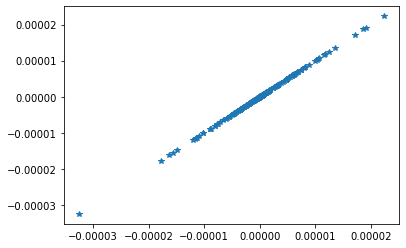

In [43]:
ds2 = ds.isel(time=slice(-months,None))
ds_climo2 = esmlab.core.climatology(ds2,freq='mon')
ds_anom2  = esmlab.core.anomaly(ds2, clim_freq='mon', time_coord_name='time') #not sure how to use slice_mon_clim_time
ds_anom2    
ds_temp = ds_anom2.sel(lat=tlat, lon=tlon, method='nearest') #select a single grid point to work with first
plt.plot(ds_temp.get(var[0]), ds_anom.get(var[0]), '*' )
anom_np = ds_anom2.get(var[0]).values # returns a 3d array with dims (time,lat,lon)
print(anom_np.shape)

In [44]:
## define function that wraps in detrending, reshaping, and SVD & returns a np.array
def svd_wrap(anom, years=years):
    theta = np.full(years, np.nan)
    varfrac = np.full(years, np.nan)
    if np.isnan(anom)[0] == False:
        #detrend results, if needed
        detrend = signal.detrend(anom)  
    
        #reshape timeseries vector into a matrix (year x month) 
        matrix=np.zeros([12, years])
        for iyr in range(years):
            matrix[0:12, iyr]=detrend[iyr*12:(iyr+1)*12] 
    
        #Call the function to calculate the singular vectors and their annual weights
        [vectors, weights]=svd.decompose(matrix) 
        [theta,varfrac]=svd.calc_redistribution(vectors, weights, matrix)

    return theta, varfrac, vectors, weights


In [45]:
print(ds_temp.get(var[0]))

<xarray.DataArray 'GPP' (time: 300)>
array([-2.230755e-07, -7.569290e-07, -4.309272e-07, ..., -8.807056e-07,
       -1.911510e-07,  4.814257e-08], dtype=float32)
Coordinates:
    lat      float64 59.84
    lon      float64 240.0
  * time     (time) object 1990-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    long_name:     gross primary production
    units:         gC/m^2/s
    cell_methods:  time: mean


In [46]:
# Make sure wrapper results are the same as above
print(theta)
[theta_wrap, varfrac_wrap, vectors_wrap, weights_wrap] = svd_wrap(ds_temp.get(var[0]).values, years)
plt.plot(theta_wrap - theta, '*') ;
plt.plot(varfrac_wrap - varfrac, '*',c='r') ;

print('----')
print(varfrac_wrap)
print('!!!')
print(varfrac)

[0.49559711 0.87611976 0.41423303 0.0273368  0.50170517 0.03259375
 0.02403053 0.60615958 0.69030682 0.21317095 0.70694026 0.02731147
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan]
12 25
[0.49559717 0.87611972 0.41423302 0.02733686 0.50170513 0.03259376
 0.02403054 0.60615964 0.69030685 0.21317109 0.70693966 0.02731228
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan]
----
[4.87384199e-01 2.61758705e-01 9.35936695e-02 6.28528080e-02
 4.55619203e-02 3.33286537e-02 1.05741837e-02 3.18925674e-03
 8.91376738e-04 4.40911760e-04 2.52950314e-04 1.71433356e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
!!!
[4.87384197e-01 2.61758708e-01 9.3593670

/glade/u/home/wwieder/python/ctsm_py/notebooks/SVD_tools.py:60: RuntimeWarning: invalid value encountered in double_scalars
  sv_theta[i] = np.abs(np.nansum(sv_vectors[i,:]))/np.nansum(np.abs(sv_vectors[i,:]))


In [47]:
print(anom_np[:,150,50].shape)
print(ds_temp.get(var[0]).values.shape)
print(np.isnan(anom_np[:,150,50])[0])

[theta_wrap, varfrac_wrap, vectors_wrap, weights_wrap] = svd_wrap(anom_np[:,150,50], years)
print(theta_wrap.shape)
print(varfrac_wrap.shape)
print(vectors_wrap.shape)
print(weights_wrap.shape)
print([years,years])

(300,)
(300,)
False
12 25
[9.59740281e-01 5.94930553e-01 3.32678988e-01 2.75502119e-01
 4.34722060e-01 6.50853572e-01 7.45339887e-01 1.64854375e-01
 6.61998431e-02 6.25716920e-03 6.57900964e-03 6.65629693e-04
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan]
(25,)
(25,)
(25, 12)
(25, 25)
[25, 25]


In [49]:
# Now try this on the full dataset
# svd_global = xr.apply_ufunc(svd_wrap, anom_np, years, vectorize=True)
da = ds.get(var[0])
dims = dict(zip(da.dims, da.shape))
#print(dims)
#print(years)
print(da.isel(lat=1, lon=1).data)
varnames = ['theta', 'varfrac', 'vectors', 'weights']
out = xr.Dataset()
theta_shape =  (years, )
out['theta'] = xr.DataArray(np.zeros(theta_shape), dims=('thetadim'))
out['varfrac'] = xr.DataArray(np.zeros(theta_shape), dims=('varfracdim'))
vector_shape = (years, 12)
out['vectors'] = xr.DataArray(np.zeros(vector_shape), dims=('vectors_dim1', 'vector_dim2'))
weights_shape = (years, years)
out['weights'] = xr.DataArray(np.zeros(weights_shape), dims=('weights_dim1', 'weights_dim2'))
    
return_vals = svd_wrap(da.isel(lat=90, lon=230).data)
for varname, vals in zip(varnames, return_vals):
    out[varname][...] = vals
    
print(out)

print(da.shape)

[0. 0. 0. ... 0. 0. 0.]
12 25
[0.71381375 0.85841431 0.27719332 0.30865014 0.1779438  0.1339587
 0.04382399 0.16624044 0.11730329 0.09291829 0.10068789 0.10882712
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan]
<xarray.Dataset>
Dimensions:  (thetadim: 25, varfracdim: 25, vector_dim2: 12, vectors_dim1: 25, weights_dim1: 25, weights_dim2: 25)
Dimensions without coordinates: thetadim, varfracdim, vector_dim2, vectors_dim1, weights_dim1, weights_dim2
Data variables:
    theta    (thetadim) float64 0.7138 0.8584 0.2772 0.3087 ... nan nan nan nan
    varfrac  (varfracdim) float64 0.5564 0.2052 0.08884 0.07575 ... 0.0 0.0 0.0
    vectors  (vectors_dim1, vector_dim2) float64 -1.936e-05 -2.541e-05 ... 0.0
    weights  (weights_dim1, weights_dim2) float64 -0.2038 -0.2749 ... 0.6764
(1980, 192, 288)


In [28]:
def calc_svd(da, nyears=years):

    dims = dict(zip(da.dims, da.shape))
    yx_shape = (dims['lat'], dims['lon'])
    # setup output variables
    out = xr.Dataset()
    varnames = ['theta', 'varfrac', 'vectors', 'weights']
    theta_shape = yx_shape + (nyears, )
    out['theta'] = xr.DataArray(np.zeros(theta_shape), dims=('lat', 'lon', 'thetadim'))
    out['varfrac'] = xr.DataArray(np.zeros(theta_shape), dims=('lat', 'lon', 'thetadim'))
    vector_shape = yx_shape + (nyears, 12)
    out['vectors'] = xr.DataArray(np.zeros(vector_shape), dims=('lat', 'lon', 'vectors_dim1', 'vector_dim2'))
    weights_shape = yx_shape + (nyears, nyears)
    out['weights'] = xr.DataArray(np.zeros(weights_shape), dims=('lat', 'lon', 'weights_dim1', 'weights_dim2'))

    # loop over all i,j points
    for (i, j), mask in np.ndenumerate(da.isel(time=0).isnull()):
        if not mask:
            return_vals = svd_wrap(da.isel(lat=i, lon=j).data)

            for varname, vals in zip(varnames, return_vals):
                out[varname][i, j, ...] = vals

    return out

In [30]:
# this step is slow, but seems to be working?

plata = calc_svd(da)

12 30
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
12 30
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
12 30
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
12 30
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
12 30
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
12 30
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
12 30
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
12 30
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

In [71]:
ds.lat.values


array([-90.       , -89.057594 , -88.11518  , -87.172775 , -86.23037  ,
       -85.28796  , -84.34555  , -83.403145 , -82.46073  , -81.518326 ,
       -80.57591  , -79.63351  , -78.6911   , -77.74869  , -76.80628  ,
       -75.86388  , -74.92146  , -73.97906  , -73.03665  , -72.09424  ,
       -71.15183  , -70.20943  , -69.26701  , -68.32461  , -67.3822   ,
       -66.43979  , -65.49738  , -64.55498  , -63.612564 , -62.67016  ,
       -61.72775  , -60.78534  , -59.842934 , -58.900524 , -57.958115 ,
       -57.015705 , -56.0733   , -55.13089  , -54.18848  , -53.246075 ,
       -52.303665 , -51.361256 , -50.41885  , -49.47644  , -48.53403  ,
       -47.59162  , -46.649216 , -45.706806 , -44.764397 , -43.82199  ,
       -42.87958  , -41.937172 , -40.994766 , -40.052357 , -39.109947 ,
       -38.167538 , -37.225132 , -36.282722 , -35.340313 , -34.397907 ,
       -33.455498 , -32.51309  , -31.57068  , -30.628273 , -29.685863 ,
       -28.743456 , -27.801046 , -26.858639 , -25.916231 , -24.9

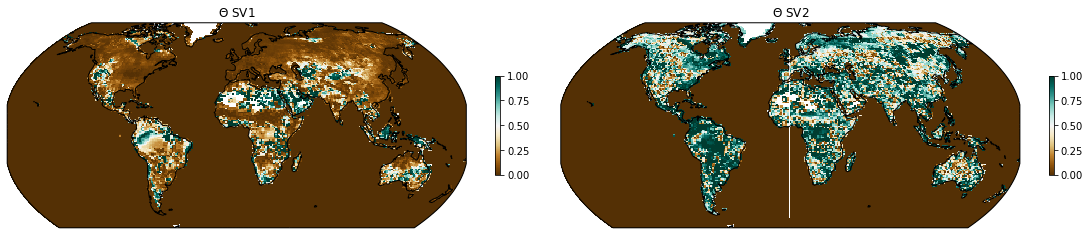

In [72]:
import matplotlib.colors as colors
import cartopy.feature as cfeature
import cartopy.crs as ccrs

vmax = 1.
vmin = 0.
fig = plt.figure(figsize=(16,20))

ax1 = fig.add_subplot(1,2,1,projection=ccrs.Robinson())
im1 = ax1.pcolormesh(ds.lon.values,ds.lat.values,plata.theta.values[:,:,0],transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='BrBG')
fig.colorbar(im1,ax=ax1,shrink=0.07,label='')
ax1.coastlines()
ax1.set_title('$\Theta$ SV1')
ax1.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())

ax2 = fig.add_subplot(1,2,2,projection=ccrs.Robinson())
im2 = ax2.pcolormesh(ds.lon.values,ds.lat.values,plata.theta.values[:,:,1],transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='BrBG')
fig.colorbar(im2,ax=ax2,shrink=0.07,label='')
ax2.coastlines()
ax2.set_title('$\Theta$ SV2')
ax2.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())
fig.tight_layout()


In [1]:
lat = ds.coords['lat']
lon = ds.coords['lon']
x0 = plata.theta[:,:,0]
x1 = plata.theta[:,:,1]

norm = colors.Normalize(vmin=0, vmax=1.)

# modified from https://unidata.github.io/MetPy/latest/examples/Four_Panel_Map.html
crs = ccrs.Robinson()#central_longitude=305.0)

# Function used to create the map subplots
def plot_background(ax):
    ax.set_global()
    ax.coastlines()
    #ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    return ax

levels = np.linspace(0, 1, 11)
fig = plt.figure(figsize=(5, 3.5),constrained_layout=True);
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(6, 10), constrained_layout=True,
                          subplot_kw={'projection': crs})

axlist = axarr.flatten()
for ax in axlist:
    plot_background(ax)
    ax.set_extent([-155, 60, -25, 60])  # I really don't understand how this works??
#    ax.set_extent([-150, 60, -25, 60])


# upper plot
cf0 = axlist[0].contourf(lon, lat, x0, levels=levels, norm=norm, cmap='gist_earth_r',
                 transform=ccrs.PlateCarree());
axlist[0].set_title('$\Theta$ SV1', fontsize=18)
axlist[0].set_axis_off()

# lower plot
cf1 = axlist[1].contourf(lon, lat, x1, levels=levels, norm=norm, cmap='gist_earth_r',
                 transform=ccrs.PlateCarree());
axlist[1].set_title('$\Theta$ SV2', fontsize=18)
axlist[1].set_axis_off()

# add common colorbar
cbar = fig.colorbar(cf1, ax=axlist.ravel().tolist(), 
                    orientation='vertical', shrink=0.80, pad=0)
#cbar.set_label('gC/m2/y', size=18, orientation='horizontal')
cbar.ax.tick_params(labelsize=16) 
ax = cbar.ax
#ax.text(0.2,-0.1,mean_dataset.attrs['units'], size=16,rotation=0)
plt.show();


NameError: name 'ds' is not defined